In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/linear_transmutation"

### Define the classes and create the data loader

In [4]:
classes = list(range(10))

branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

In [6]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import the models

In [7]:
# Create the SDE and import model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1

linear_model = model_util.load_model(
    image_unet.LabelGuidedMNISTUNetTimeConcat,
    "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/mnist_continuous_alldigits_labelguided/2/last_ckpt.pth"
).to(DEVICE)

branched_model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat,
    "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/mnist_continuous_alldigits/2/epoch_90_ckpt.pth"
).to(DEVICE)

### Transmutation

/local/18890138/ipykernel_27240/329429412.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_1_tens, orig_2_tens = torch.tensor(orig_1).to(DEVICE), torch.tensor(orig_2).to(DEVICE)


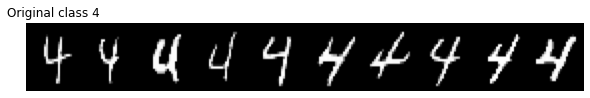

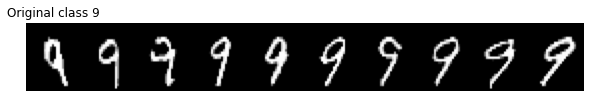

In [46]:
class_1, class_2 = 4, 9
branch_time = 0.3483483483483483

rng_1 = np.random.RandomState(53)
rng_2 = np.random.RandomState(23)

inds_1 = rng_1.choice(np.where(dataset.targets == class_1)[0], size=10, replace=False)
inds_2 = rng_2.choice(np.where(dataset.targets == class_2)[0], size=10, replace=False)
inds_1 = inds_1[np.array([4, 7, 9, 0, 5, 6, 8, 1, 2, 3])]
inds_2 = inds_2[np.array([1, 4, 7, 3, 6, 8, 2, 0, 5, 9])]

orig_1 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in inds_1
])
orig_2 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in inds_2
])

orig_1_tens, orig_2_tens = torch.tensor(orig_1).to(DEVICE), torch.tensor(orig_2).to(DEVICE)

plot_mnist_digits(orig_1.cpu().numpy(), grid_size=(10, 1), title=("Original class %d" % class_1))
plt.savefig(os.path.join(out_path, "orig_%d.svg" % class_1), format="svg")
plot_mnist_digits(orig_2.cpu().numpy(), grid_size=(10, 1), title=("Original class %d" % class_2))
plt.savefig(os.path.join(out_path, "orig_%d.svg" % class_2), format="svg")
plt.show()

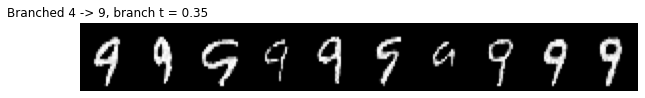

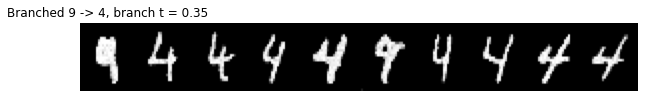

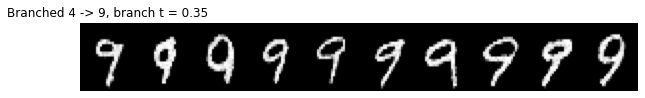

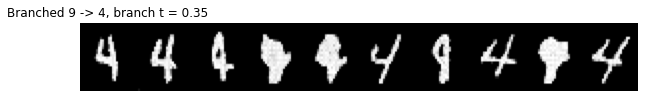

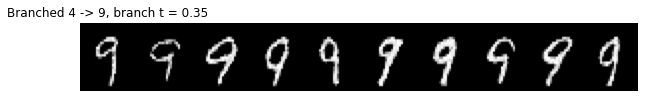

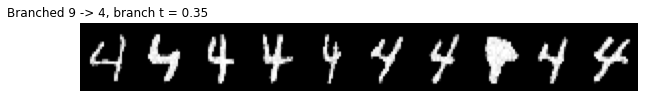

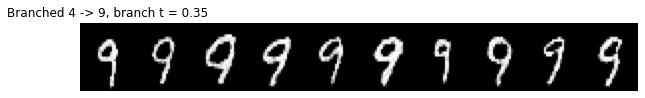

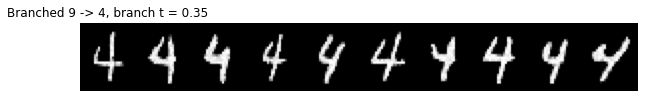

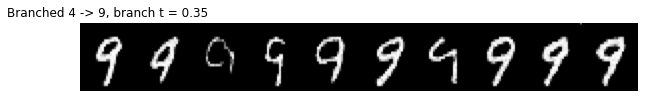

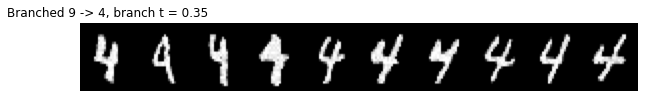

In [47]:
# Branched transmutation
for i in range(5):
    forward_1_to_2 = sde.forward(
        orig_1_tens, torch.ones(len(orig_1_tens)).to(DEVICE) * branch_time
    )[0].float()
    forward_2_to_1 = sde.forward(
        orig_2_tens, torch.ones(len(orig_2_tens)).to(DEVICE) * branch_time
    )[0].float()

    backward_1_to_2 = generate.generate_continuous_branched_samples(
        branched_model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
        t_limit=branch_time, num_samples=orig_1.shape[0], initial_samples=forward_1_to_2,
        num_steps=500
    )
    backward_2_to_1 = generate.generate_continuous_branched_samples(
        branched_model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
        t_limit=branch_time, num_samples=orig_2.shape[0], initial_samples=forward_2_to_1,
        num_steps=500
    )

    plot_mnist_digits(backward_1_to_2.cpu().numpy(), grid_size=(10, 1), title=("Branched %d -> %d, branch t = %.2f" % (class_1, class_2, branch_time)))
    plt.savefig(os.path.join(out_path, "branched_%d_to_%d_tb%.2f_%d.svg" % (class_1, class_2, branch_time, i)), format="svg")
    plot_mnist_digits(backward_2_to_1.cpu().numpy(), grid_size=(10, 1), title=("Branched %d -> %d, branch t = %.2f" % (class_2, class_1, branch_time)))
    plt.savefig(os.path.join(out_path, "branched_%d_to_%d_tb%.2f_%d.svg" % (class_2, class_1, branch_time, i)), format="svg")
    plt.show()

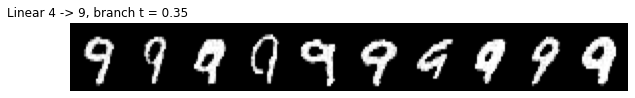

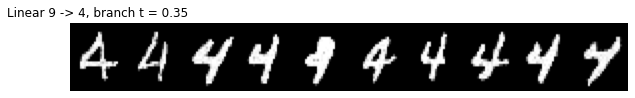

In [61]:
# Linear transmutation
branch_points = np.arange(0.05, 1, 0.1)

for t_i, t in enumerate(branch_points):
    if abs(t - 0.35) > 0.0001:
        continue
    forward_1_to_2 = sde.forward(
        orig_1_tens, torch.ones(len(orig_1_tens)).to(DEVICE) * t
    )[0].float()
    forward_2_to_1 = sde.forward(
        orig_2_tens, torch.ones(len(orig_2_tens)).to(DEVICE) * t
    )[0].float()
    
    backward_1_to_2 = generate.generate_continuous_label_guided_samples(
        linear_model, sde, class_2, class_to_class_index_tensor, sampler="pc",
        t_limit=t, num_samples=orig_1.shape[0], initial_samples=forward_1_to_2,
        num_steps=int(t * 1000)
    )
    backward_2_to_1 = generate.generate_continuous_label_guided_samples(
        linear_model, sde, class_1, class_to_class_index_tensor, sampler="pc",
        t_limit=t, num_samples=orig_2.shape[0], initial_samples=forward_2_to_1,
        num_steps=int(t * 1000)
    )
    
    plot_mnist_digits(backward_1_to_2.cpu().numpy(), grid_size=(10, 1), title=("Linear %d -> %d, branch t = %.2f" % (class_1, class_2, t)))
    plt.savefig(os.path.join(out_path, "linear_%d_to_%d_tb%.2f.svg" % (class_1, class_2, t)), format="svg")
    plot_mnist_digits(backward_2_to_1.cpu().numpy(), grid_size=(10, 1), title=("Linear %d -> %d, branch t = %.2f" % (class_2, class_1, t)))
    plt.savefig(os.path.join(out_path, "linear_%d_to_%d_tb%.2f.svg" % (class_2, class_1, t)), format="svg")
    plt.show()